# Project 1 – Decision Trees and Random Forests

#### Imports
Imports og random seed

In [79]:


import numpy as np

from itertools import product
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from decision_tree import DecisionTree
from random_forest import RandomForest

# random seed (bare satt en tilfeldig verdi)
RANDOM_SEED = 21



### Load dataset

Laster inn letters.csv og deler opp i features (X) og labels (y), og deler inn i test/train datasett (80/20)

In [80]:
data = np.genfromtxt("letters.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[f] for f in feature_names]).T
y = data[target_name].astype(int)

# 80/20 train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0, shuffle=True, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")

X_train shape: (1600, 16), y_train shape: (1600,)
X_test shape: (400, 16), y_test shape: (400,)
Feature columns names: ['xbox', 'ybox', 'width', 'high', 'onpix', 'xbar', 'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'xege', 'xegvy', 'yege', 'yegvx']
Target column name: label


### Hyperparametere

Setter opp verdier som skal testes i grid search for DecisionTree og RandomForest.

In [81]:
dt_params = {
    "criterion": ["entropy", "gini"],
    "max_depth": [None, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"],
}

rf_params = {
    "n_estimators": [10, 20, 40],
    "max_depth": [5, 10, None],
    "criterion": ["entropy", "gini"],
    "max_features": ["sqrt", "log2"],
}


### Cross-validation

Funksjon for k-fold cross validation som regner ut accuracy.

In [82]:
def cross_val_score(model_class, params, X, y, k=5, seed=RANDOM_SEED):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_class(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))
    return float(np.mean(scores))


### DecisionTree grid search

Tester kombinasjoner av hyperparametere og finner beste for DecisionTree.

In [83]:
results_dt = []
best_dt_params = None
best_dt_score = -1.0

for criterion, max_depth, max_features in product(
    dt_params["criterion"], dt_params["max_depth"], dt_params["max_features"]
):
    params = {
        "criterion": criterion,
        "max_depth": max_depth,
        "max_features": max_features,
    }
    score = cross_val_score(
        DecisionTree, params, X_train, y_train, k=5, seed=RANDOM_SEED
    )
    mean_score = np.mean(score)

    # lagre alle resultater
    results_dt.append({**params, "cv_score": mean_score})

    # oppdater best score
    if mean_score > best_dt_score:
        best_dt_score = mean_score
        best_dt_params = params

df_dt_results = pd.DataFrame(results_dt).sort_values(by="cv_score", ascending=False)

print("Best DecisionTree params:", best_dt_params)
print("Best DecisionTree 5-fold CV accuracy:", round(best_dt_score, 4))
df_dt_results.head()


Best DecisionTree params: {'criterion': 'entropy', 'max_depth': None, 'max_features': None}
Best DecisionTree 5-fold CV accuracy: 0.8838


,criterion,max_depth,max_features,cv_score
0,entropy,NaN,None,0.883750
21,gini,20.0,None,0.882500
18,gini,10.0,None,0.881250
12,gini,NaN,None,0.878125
6,entropy,10.0,None,0.877500


### RandomForset - grid Serach
Tester kombinasjoner av hyperparametere og finner beste for RandomForest.

In [84]:
results_rf = []
best_rf_params = None
best_rf_score = -1.0

for n_estimators, max_depth, criterion, max_features in product(
    rf_params["n_estimators"],
    rf_params["max_depth"],
    rf_params["criterion"],
    rf_params["max_features"],
):
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "criterion": criterion,
        "max_features": max_features,
    }
    score = cross_val_score(
        RandomForest, params, X_train, y_train, k=5, seed=RANDOM_SEED
    )
    mean_score = np.mean(score)

    # lagre alle resultater
    results_rf.append({**params, "cv_score": mean_score})

    # oppdater best score
    if mean_score > best_rf_score:
        best_rf_score = mean_score
        best_rf_params = params

df_rf_results = pd.DataFrame(results_rf).sort_values(by="cv_score", ascending=False)

print("Best RandomForest params:", best_rf_params)
print("Best RandomForest 5-fold CV accuracy:", round(best_rf_score, 4))
df_rf_results.head()


Best RandomForest params: {'n_estimators': 40, 'max_depth': 10, 'criterion': 'entropy', 'max_features': 'log2'}
Best RandomForest 5-fold CV accuracy: 0.9644


,n_estimators,max_depth,criterion,max_features,cv_score
29,40,10.0,entropy,log2,0.964375
32,40,NaN,entropy,sqrt,0.963125
33,40,NaN,entropy,log2,0.962500
28,40,10.0,entropy,sqrt,0.961875
31,40,10.0,gini,log2,0.961875


## DecisionTree accuracy vs max_depth


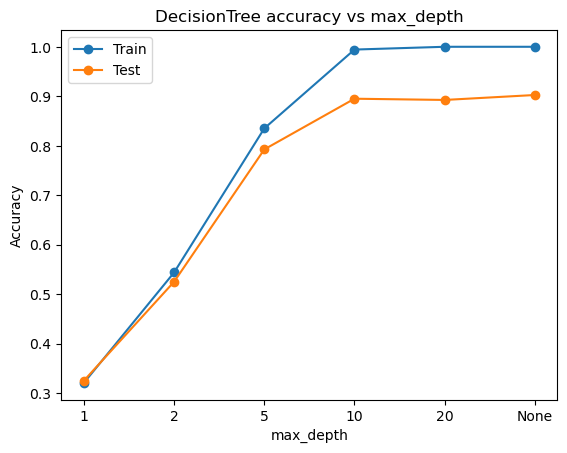

In [85]:
depths = [1, 2, 5, 10, 20, None]
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTree(max_depth=d, criterion="gini", max_features=None)
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train")
plt.plot([str(d) for d in depths], test_scores, marker="o", label="Test")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("DecisionTree accuracy vs max_depth")
plt.legend()
plt.show()

## RandomForest accuracy vs n_estimator

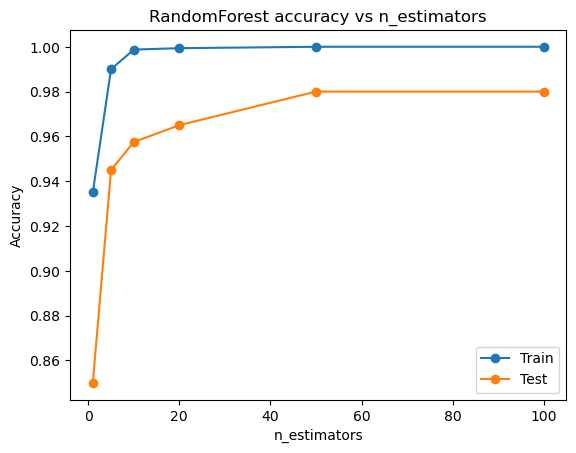

In [86]:
estimators = [1, 5, 10, 20, 50, 100]
train_scores = []
test_scores = []

for n in estimators:
    model = RandomForest(n_estimators=n, max_depth=10, criterion="gini", max_features="sqrt")
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(estimators, train_scores, marker="o", label="Train")
plt.plot(estimators, test_scores, marker="o", label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("RandomForest accuracy vs n_estimators")
plt.legend()
plt.show()

### Final evaluation

We retrain our models with the best hyperparameters on the full training set and evaluate on the test set.


In [87]:
# DecisionTree
dt_best = DecisionTree(**best_dt_params)
dt_best.fit(X_train, y_train)
dt_pred = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

# RandomForest
rf_best = RandomForest(**best_rf_params)
rf_best.fit(X_train, y_train)
rf_pred = rf_best.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Print accuracy
print(f"Custom DecisionTree test accuracy: {dt_acc:.4f}")
print(f"Custom RandomForest test accuracy: {rf_acc:.4f}")


Custom DecisionTree test accuracy: 0.9075
Custom RandomForest test accuracy: 0.9800


### SKLearn modeller

Trener modell med sklearn med de samme paramterene

In [88]:
# Sklearn DecisionTree
sk_dt = DecisionTreeClassifier(
    criterion=best_dt_params["criterion"],
    max_depth=best_dt_params["max_depth"],
    max_features=best_dt_params["max_features"],
    random_state=0,
)
sk_dt.fit(X_train, y_train)
sk_dt_acc = accuracy_score(y_test, sk_dt.predict(X_test))

# Sklearn RandomForest
sk_rf = RandomForestClassifier(
    n_estimators=best_rf_params["n_estimators"],
    max_depth=best_rf_params["max_depth"],
    criterion=best_rf_params["criterion"],
    max_features=best_rf_params["max_features"],
    random_state=0,
)
sk_rf.fit(X_train, y_train)
sk_rf_acc = accuracy_score(y_test, sk_rf.predict(X_test))

print("Sklearn DecisionTree test accuracy:", round(sk_dt_acc, 4))
print("Sklearn RandomForest test accuracy:", round(sk_rf_acc, 4))


Sklearn DecisionTree test accuracy: 0.93
Sklearn RandomForest test accuracy: 0.99


#### Task 4 - Permutation Importance

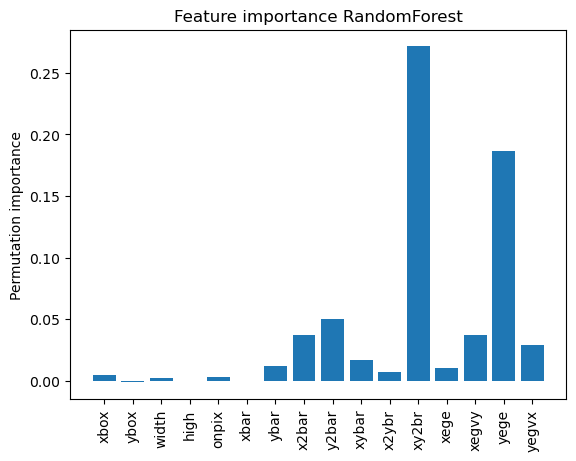

In [89]:
def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=30, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    baseline = metric(y, model.predict(X))
    importances = []

    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, col])
            score = metric(y, model.predict(X_permuted))
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return np.array(importances)

rf_best = RandomForest(**best_rf_params)
rf_best.fit(X_train, y_train)

importances = permutation_importance(rf_best, X_test, y_test, n_repeats=30, seed=RANDOM_SEED)

import matplotlib.pyplot as plt

plt.bar(range(len(feature_names)), importances)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.ylabel("Permutation importance")
plt.title("Feature importance RandomForest")
plt.show()
